# Finding the emotion palette of famous Indian directors
![Emotion in different scenes](https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/images/movie-analysis.png)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/05-emotion-palette.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/05-emotion-palette.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/05-emotion-palette.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

[EVA](https://github.com/georgia-tech-db/eva) is a new database system tailored for video analytics -- think MySQL for videos. It supports a simple SQL-like language for querying videos (e.g., finding frames in a movie with your favorite actor or find touchdowns in a football game). It comes with a wide range of commonly used computer vision models.

Why EVA?

👀 Easily query videos in user-facing applications with a simple SQL-like interface for commonly used computer vision models.

🚅 Speed up queries and save money spent on model inference using in-built sampling, caching, and filtering optimizations.

✨ Hit your target accuracy using state-of-the-art model selection and query optimization algorithms.

In this notebook, we show how to use the EVA database system to compare the "emotion palettes" of two renowned directors -- Sanjay Leela Bhansali and Mani Ratnam -- by examing the range of emotions in a their movie scenes.

## Start EVA Server
We first initialize and launch the EVA server using the start server notebook. We then estabish a connection to the launched server.

In [ ]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

## Downloading necessary files

Here, we download the movie clips for analysis. EVA leverages existing computer vision models in the form of user-defined functions (UDFs) that can be directly imported and used to process videos. Here, we download the necessary UDF definition files for this task - (1) face detector and (2) emotion detector.

In [ ]:
import os
import pandas as pd
# Links for the movies
!mkdir movies
os.chdir('./movies')

# A few clips from director Mani Ratnam's movies
mani_movies = ['raavan.mp4', 'chekka chivantha vaanam.mp4', 'kadal.mp4', 'OK kanmani.mp4', 'kaatry veliyidai.mp4']
!wget -nc https://www.dropbox.com/s/vi1d23u3eb8ozzy/chekka%20chivantha%20vaanam.mp4
!wget -nc https://www.dropbox.com/s/9btsg6wlu6rtkar/kaatry%20veliyidai.mp4
!wget -nc https://www.dropbox.com/s/gz34z5pk2nlabxz/kadal.mp4
!wget -nc https://www.dropbox.com/s/yke92yaequjadfm/OK%20kanmani.mp4
!wget -nc https://www.dropbox.com/s/dfifka1an20935e/raavan.mp4

# A few clips from director Sanjay Leela Bhansali's movies
sanjay_movies = ['ramleela.mp4', 'gangubai kathiawadi.mp4', 'bajirao mastani.mp4', 'padmaavat.mp4']
!wget -nc https://www.dropbox.com/s/41kcmny1sfo70ez/bajirao%20mastani.mp4
!wget -nc https://www.dropbox.com/s/48h04esklypcu9u/gangubai%20kathiawadi.mp4
!wget -nc https://www.dropbox.com/s/knvce0irw69f3vq/padmaavat.mp4
!wget -nc https://www.dropbox.com/s/d5345mfeddruau6/ramleela.mp4

os.chdir('..')
MOVIES_DIR = str(os.getcwd()) + '/movies/'

# Links for the user-defined functions
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/face_detector.py
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/emotion_detector.py

## Visualize Video Clip

In [ ]:
from IPython.display import Video
Video(f'{MOVIES_DIR}{sanjay_movies[1]}', height=450, width=800, embed=True)

## Loading the video files in EVA

Loading the video files into EVA can be done in the single line command as shown. This command creates the table named `ravaan`, etc. in the EVA database and also generates the necessary metadata.

In [5]:
# Adding the movies to eva

def add_directors_movie(list_of_movies, name):
    for i in range(len(list_of_movies)):
        print(f'load file "{MOVIES_DIR+list_of_movies[i]}" into {name}{i}')
        cursor.execute(f'load file "{MOVIES_DIR+list_of_movies[i]}" into {name}{i}')
        response = cursor.fetch_all()
        print(response)

# Adding movies for Mani Ratnam
add_directors_movie(mani_movies, 'mani')

# Adding movies for Sanjay Leela Bhansali
add_directors_movie(sanjay_movies, 'sanjay')

load file "/workspace/use_eva/capstone/movies_clip/mani/raavan.mp4" into mani0
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Video successfully added at location: /workspa...
@batch_size: 1
@identifier_column: None
@query_time: 0.33855174200016336
load file "/workspace/use_eva/capstone/movies_clip/mani/chekka chivantha vaanam.mp4" into mani1
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Video successfully added at location: /workspa...
@batch_size: 1
@identifier_column: None
@query_time: 0.36851971200030675
load file "/workspace/use_eva/capstone/movies_clip/mani/kadal.mp4" into mani2
@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Video successfully added at location: /workspa...
@batch_size: 1
@identifier_column: None
@query_time: 0.49542117099963434
load file "/workspace/use_eva/capstone/movies_clip/mani/OK kanmani.mp4" int

## Defing the User-Defined Functions (UDF)

As described earlier, EVA uses UDFs to perform computer vision tasks. Here, we create the UDFs inside the EVA database using the UDF definition files that we downloaded earlier.

In [7]:
# Defining the UDFs
cursor.execute("""CREATE UDF IF NOT EXISTS EmotionDetector 
        INPUT (frame NDARRAY UINT8(3, ANYDIM, ANYDIM)) 
        OUTPUT (labels NDARRAY STR(ANYDIM), scores NDARRAY FLOAT32(ANYDIM)) 
        TYPE  Classification IMPL 'emotion_detector.py';
        """)
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF FaceDetector
                  INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
                  OUTPUT (bboxes NDARRAY FLOAT32(ANYDIM, 4),
                          scores NDARRAY FLOAT32(ANYDIM))
                  TYPE  FaceDetection
                  IMPL  'face_detector.py';
        """)
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  UDF EmotionDetector already exists, nothing ad...
@batch_size: 1
@identifier_column: None
@query_time: 0.12246903100094642
@status: -1
@batch: None
@error: UDF FaceDetector already exists.


## Running the User-Defined Functions

Now that we have created the UDFs and loaded our video into EVA, we are ready to run some queries on the video and see the magic happen! 

Using the EVA-QL query shown below, we can retrieve the faces of all the actors and their respective emotions in the video sequence.

This step will take some time.

In [8]:
def run_udf_for_movie(movie_name):
    cursor.execute(f"""SELECT id, Face.bbox, Emotion.label, Emotion.conf
                       FROM  {movie_name}
                          JOIN LATERAL  Unnest(FaceDetector(data)) AS Face(bbox, conf) 
                          JOIN LATERAL EmotionDetector(Crop(data, bbox)) AS Emotion (label, conf)
                       WHERE Face.conf > 0.85 AND Emotion.conf > 0.5;
                    """
                   )
    response = cursor.fetch_all()
    return response.batch.frames

# Getting the emotions of Mani Ratnam's movies
mani_movie_emo = run_udf_for_movie('mani0')
for i in range(1, len(mani_movies)):
    temp = run_udf_for_movie(f'mani{i}')
    frames = [mani_movie_emo, temp]
    mani_movie_emo = pd.concat(frames)

# Getting the emotions of Sanjay Leela Bhansali's movies
sanjay_movie_emo = run_udf_for_movie('sanjay0')
for i in range(len(sanjay_movies)):
    temp = run_udf_for_movie(f'sanjay{i}')
    frames = [sanjay_movie_emo, temp]
    sanjay_movie_emo = pd.concat(frames)

In [21]:
sanjay_movie_emo

,sanjay0.id,Face.bbox,Emotion.label,Emotion.conf,sanjay1.id,sanjay2.id,sanjay3.id
0,1100.0,"[504.8017578125, 139.7993621826, 524.858886718...",fear,0.841712,NaN,NaN,NaN
1,1200.0,"[475.1665344238, 205.4287109375, 536.994445800...",sad,0.718062,NaN,NaN,NaN
2,1300.0,"[397.6219787598, 143.2802429199, 500.978240966...",happy,0.947466,NaN,NaN,NaN
3,1400.0,"[308.6485290527, 128.33644104, 448.0209655762,...",neutral,0.716652,NaN,NaN,NaN
4,1500.0,"[363.8956604004, 89.7442169189, 516.801574707,...",sad,0.772794,NaN,NaN,NaN
...,...,...,...,...,...,...,...
14,NaN,"[357.087310791, 128.2056884766, 461.6723632812...",angry,0.655766,NaN,NaN,2628.0
15,NaN,"[429.6559448242, 146.4176940918, 454.447601318...",sad,0.964848,NaN,NaN,3228.0
16,NaN,"[361.1128845215, 149.0170593262, 440.821777343...",angry,0.995276,NaN,NaN,3528.0
17,NaN,"[487.2916259766, 105.6031265259, 639.592773437...",sad,0.650092,NaN,NaN,3928.0


## Visualising the results

Here, we show the distribution of the different emotions that EVA found in the scenes made by the two directors. 

Interstingly, we see that in these movie clips, Mani's movies tend to have more happy and less sad emotions compared to those in Sanjay's movies. We note that the emotion detector might make a few errors. To minimize their impact, we only focus on highly confident results from the model.

<AxesSubplot:title={'center':"Emotion palette of Sanjay Leela Bhansali's movies"}, ylabel='Emotion.conf'>

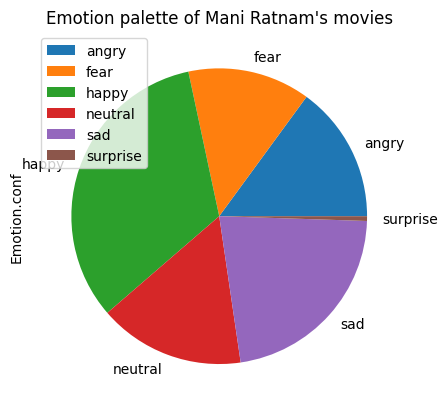

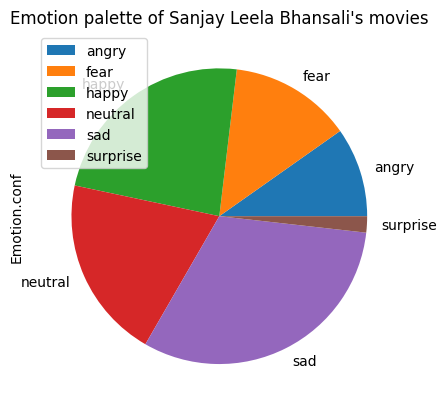

In [10]:
mani_movie_emo.groupby(['Emotion.label']).count().plot(kind='pie', y='Emotion.conf', title="Emotion palette of Mani Ratnam's movies")
sanjay_movie_emo.groupby(['Emotion.label']).count().plot(kind='pie', y='Emotion.conf', title="Emotion palette of Sanjay Leela Bhansali's movies")

## Finding Intense Frames

Here, we retrieve a few intense frames with high emotions from these clips.

In [27]:
def get_name_df(movie_name):
    name = ''
    df = pd.DataFrame()
    try:
        name = f'mani{mani_movies.index(movie_name)}'
        df = mani_movie_emo.dropna(subset=[f'{name}.id'])
    except:
        try:
            name = f'sanjay{sanjay_movies.index(movie_name)}'
            df = sanjay_movie_emo.dropna(subset=[f'{name}.id'])
        except:
            print('wrong movie name')
    return name,df

In [32]:
import numpy as np

# pickany movie of you choice
movie_name = sanjay_movies[2]
name, df = get_name_df(movie_name)
df = run_udf_for_movie(name)

emotions = df['Emotion.label'].to_numpy()
ids = df[f'{name}.id'].to_numpy()
print(len(emotions), len(ids))

38 38


In [33]:
data = zip(ids, emotions)
from itertools import groupby
emotes = [list(j) for i, j in groupby(data, lambda x: x[1])]
emotion_groups = []
for item in emotes:
    start = item[0][0]
    end = item[-1][0]
    emote = item[0][1]
    if (end - start > 50):
        emotion_groups.append((start, end, emote))
print(emotion_groups)
prev = emotion_groups[0]
changing_emotions = set()
for item in emotion_groups[1:]:
    if item[2] != prev[2]:
        changing_emotions.add(prev)
        changing_emotions.add(item)
    prev = item
print(sorted(changing_emotions, key=lambda x: x[0]))
change_idxs = sorted([np.random.randint(a,b) for a,b, _ in changing_emotions])
print(change_idxs)

[(2400, 2500, 'neutral'), (2900, 3200, 'sad'), (348, 2048, 'sad'), (2396, 2496, 'neutral')]
[(348, 2048, 'sad'), (2396, 2496, 'neutral'), (2400, 2500, 'neutral'), (2900, 3200, 'sad')]
[348, 2396, 2400, 2900]


In [34]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt
import ast

def img_show(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

def view_frames(video_path, frame_data, id_name):
    color1=(207, 248, 64)
    color2=(0, 0, 255)
    thickness=4
    
    vcap = cv2.VideoCapture(video_path)
    frame_id = 0
    ret, frame = vcap.read()
    while ret:
        df = frame_data[frame_data[id_name] == frame_id]
        img = frame
        if df.size:
            label = df['Emotion.label'].tolist()[0]
            bbox = df['Face.bbox'].tolist()[0]
            
            x1,y1,x2,y2 = bbox
            
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            
            img=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
            # object label
            cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
            # frame label
            cv2.putText(img, 'Frame ID: ' + str(frame_id), (900, 1000), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
           
            img_show(img)
            
        frame_id +=1
        ret,frame = vcap.read()
    vcap.release()

4


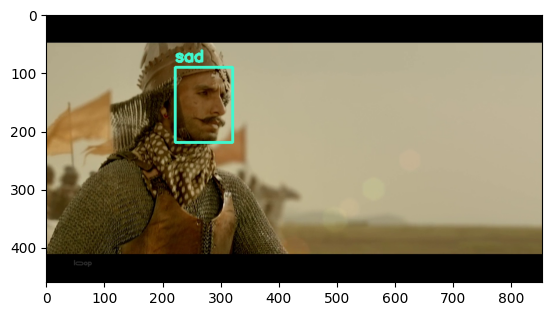

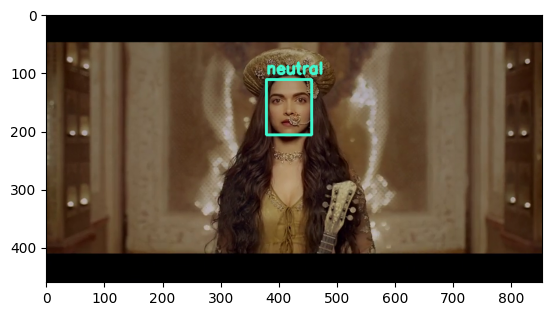

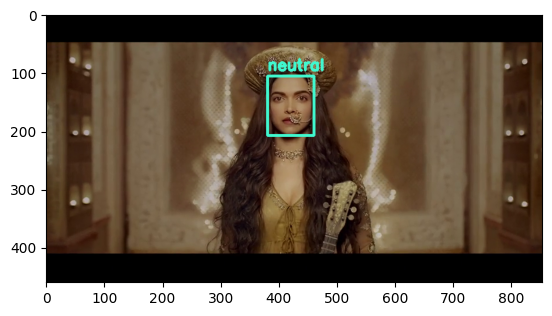

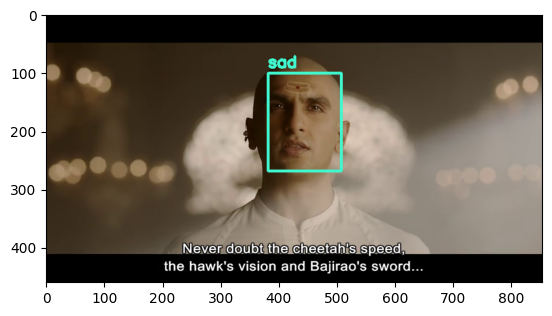

In [37]:
m = df.loc[df[f'{name}.id'].isin(change_idxs)]
print(len(m))
input_path = f'{MOVIES_DIR + movie_name}'
id_name = f'{name}.id'
view_frames(input_path, m, id_name)